In [1]:
datapaths = [
    "finetune_evals/2025-12-03-23-49-37_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_TriviaMC_n500_comparison.jsonl",
    "finetune_evals/2025-12-04-00-23-02_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_PopMC_0_difficulty_filtered_test_n500_comparison.jsonl",
    "finetune_evals/2025-12-04-02-49-08_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_SimpleMC_n500_comparison.jsonl",
    "finetune_evals/mlq_2_2025-12-06-22-26-12_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_ml_code_questions_n98_comparison.jsonl"
]

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ks_2samp
from collections import Counter
import os

# Confidence bin midpoints (A-H)
CONFIDENCE_BINS = {
    'A': 2.5,
    'B': 7.5,
    'C': 15.0,
    'D': 30.0,
    'E': 50.0,
    'F': 70.0,
    'G': 85.0,
    'H': 95.0
}

BIN_MIDPOINTS = np.array([2.5, 7.5, 15, 30, 50, 70, 85, 95])


In [3]:
def load_comparison_data(filepath):
    """Load data from a comparison jsonl file."""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

def extract_confidence_values(data):
    """Extract self and other confidence values from data."""
    self_conf = []
    other_conf = []
    self_conf_letters = []
    other_conf_letters = []
    
    for item in data:
        if 'expected_confidence' in item:
            self_conf.append(item['expected_confidence'])
        if 'expected_other_confidence' in item:
            other_conf.append(item['expected_other_confidence'])
        if 'predicted_confidence_letter' in item:
            self_conf_letters.append(item['predicted_confidence_letter'])
        # Note: other confidence letter might not be in the data
    
    return {
        'self_conf': np.array(self_conf),
        'other_conf': np.array(other_conf),
        'self_conf_letters': self_conf_letters,
    }

def numeric_to_bin_distribution(conf_values):
    """Convert numeric confidence values to bin probability distribution."""
    # Map each value to the closest bin midpoint
    bin_probs = np.zeros(8)
    for val in conf_values:
        # Find closest bin
        idx = np.argmin(np.abs(BIN_MIDPOINTS - val))
        bin_probs[idx] += 1
    # Normalize to probability distribution
    if bin_probs.sum() > 0:
        bin_probs = bin_probs / bin_probs.sum()
    return bin_probs


In [4]:
def compute_mean_absolute_difference(self_conf, other_conf):
    """Compute mean absolute difference between self and other confidence."""
    if len(self_conf) != len(other_conf):
        return None
    return np.mean(np.abs(self_conf - other_conf))

def compute_correlation(self_conf, other_conf):
    """Compute Pearson correlation between self and other confidence."""
    if len(self_conf) != len(other_conf) or len(self_conf) < 2:
        return None, None
    corr, p_value = pearsonr(self_conf, other_conf)
    return corr, p_value

def compute_kl_divergence(self_conf, other_conf):
    """Compute KL divergence between self and other confidence distributions."""
    self_dist = numeric_to_bin_distribution(self_conf)
    other_dist = numeric_to_bin_distribution(other_conf)
    
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    self_dist = self_dist + epsilon
    other_dist = other_dist + epsilon
    self_dist = self_dist / self_dist.sum()
    other_dist = other_dist / other_dist.sum()
    
    # KL divergence: sum(p * log(p / q))
    kl = np.sum(self_dist * np.log(self_dist / other_dist))
    return kl

def compute_ks_test(self_conf, other_conf):
    """Compute Kolmogorov-Smirnov test statistic."""
    if len(self_conf) == 0 or len(other_conf) == 0:
        return None, None
    statistic, p_value = ks_2samp(self_conf, other_conf)
    return statistic, p_value

def compute_bin_wise_differences(self_conf_letters, other_conf_letters=None):
    """Compute differences in confidence bin distributions."""
    if other_conf_letters is None or len(other_conf_letters) == 0:
        # If we don't have other confidence letters, return None
        return None
    
    self_bin_counts = Counter(self_conf_letters)
    other_bin_counts = Counter(other_conf_letters)
    
    # Normalize to probabilities
    total_self = sum(self_bin_counts.values())
    total_other = sum(other_bin_counts.values())
    
    if total_self == 0 or total_other == 0:
        return None
    
    self_probs = {bin: self_bin_counts.get(bin, 0) / total_self for bin in 'ABCDEFGH'}
    other_probs = {bin: other_bin_counts.get(bin, 0) / total_other for bin in 'ABCDEFGH'}
    
    # Compute absolute differences
    differences = {bin: abs(self_probs[bin] - other_probs[bin]) for bin in 'ABCDEFGH'}
    mean_diff = np.mean(list(differences.values()))
    
    return {
        'self_probs': self_probs,
        'other_probs': other_probs,
        'differences': differences,
        'mean_absolute_difference': mean_diff
    }

def parse_model_type_and_test(filename):
    """Parse filename to determine model type (base/finetuned) and test name."""
    # Check if it's a base model
    if '_base_' in filename or filename.endswith('_base.jsonl'):
        model_type = 'base'
    elif 'llm_metacognition' in filename or 'step-' in filename or 'wbtl9xqu' in filename:
        model_type = 'finetuned'
    else:
        # Default to finetuned if we can't determine
        model_type = 'finetuned'
    
    # Extract test/dataset name
    # Look for common patterns: dataset names before _n or _comparison
    test_name = 'unknown'
    
    # Common dataset patterns
    if 'TriviaMC' in filename:
        test_name = 'TriviaMC'
    elif 'PopMC' in filename:
        test_name = 'PopMC'
    elif 'SimpleMC' in filename:
        test_name = 'SimpleMC'
    elif 'ml_code_questions' in filename or 'mlq' in filename:
        test_name = 'ML Code Questions'
    else:
        # Try to extract from filename - look for text before _n or _comparison
        parts = filename.replace('_comparison.jsonl', '').split('_')
        # Find the dataset name (usually before _n or at the end)
        for i, part in enumerate(parts):
            if part.startswith('n') and part[1:].isdigit():
                # Take the part before this
                if i > 0:
                    test_name = parts[i-1]
                    break
        if test_name == 'unknown':
            # Try last meaningful part before extension
            test_name = parts[-1] if parts else 'unknown'
    
    return model_type, test_name


In [5]:
def analyze_file(filepath):
    """Analyze a single comparison file and return all metrics."""
    filename = os.path.basename(filepath)
    print(f"\nAnalyzing: {filename}")
    
    # Parse model type and test name
    model_type, test_name = parse_model_type_and_test(filename)
    print(f"  Model type: {model_type}, Test: {test_name}")
    
    # Load data
    data = load_comparison_data(filepath)
    if len(data) == 0:
        print("  No data found!")
        return None
    
    # Extract confidence values
    conf_data = extract_confidence_values(data)
    self_conf = conf_data['self_conf']
    other_conf = conf_data['other_conf']
    self_conf_letters = conf_data['self_conf_letters']
    
    if len(self_conf) == 0 or len(other_conf) == 0:
        print("  Missing confidence data!")
        return None
    
    print(f"  Loaded {len(data)} samples")
    print(f"  Self confidence: mean={np.mean(self_conf):.2f}, std={np.std(self_conf):.2f}")
    print(f"  Other confidence: mean={np.mean(other_conf):.2f}, std={np.std(other_conf):.2f}")
    
    # Compute difference of means: Mean(self) - Mean(other)
    mean_self = float(np.mean(self_conf))
    mean_other = float(np.mean(other_conf))
    mean_diff = mean_self - mean_other
    
    # Compute metrics
    results = {
        'filepath': filepath,
        'filename': filename,
        'model_type': model_type,
        'test_name': test_name,
        'n_samples': len(data),
        'self_conf_mean': float(np.mean(self_conf)),
        'self_conf_std': float(np.std(self_conf)),
        'other_conf_mean': float(np.mean(other_conf)),
        'other_conf_std': float(np.std(other_conf)),
        'mean_diff_self_minus_other': mean_diff,
    }
    
    # Mean Absolute Difference
    mad = compute_mean_absolute_difference(self_conf, other_conf)
    results['mean_absolute_difference'] = float(mad) if mad is not None else None
    
    # Correlation
    corr, corr_p = compute_correlation(self_conf, other_conf)
    results['correlation'] = float(corr) if corr is not None else None
    results['correlation_p_value'] = float(corr_p) if corr_p is not None else None
    
    # KL Divergence
    kl = compute_kl_divergence(self_conf, other_conf)
    results['kl_divergence'] = float(kl) if kl is not None else None
    
    # KS Test
    ks_stat, ks_p = compute_ks_test(self_conf, other_conf)
    results['ks_statistic'] = float(ks_stat) if ks_stat is not None else None
    results['ks_p_value'] = float(ks_p) if ks_p is not None else None
    
    # Bin-wise differences (if we have letter data)
    if len(self_conf_letters) > 0:
        # Try to extract other confidence letters if available
        other_conf_letters = []
        for item in data:
            # Check if there's an other confidence letter field
            if 'predicted_other_confidence_letter' in item:
                other_conf_letters.append(item['predicted_other_confidence_letter'])
        
        if len(other_conf_letters) > 0:
            bin_diff = compute_bin_wise_differences(self_conf_letters, other_conf_letters)
            if bin_diff:
                results['bin_mean_absolute_difference'] = bin_diff['mean_absolute_difference']
                results['bin_differences'] = bin_diff['differences']
    
    return results


In [6]:
# Analyze all files
all_results = []
for filepath in datapaths:
    if os.path.exists(filepath):
        result = analyze_file(filepath)
        if result:
            all_results.append(result)
    else:
        print(f"File not found: {filepath}")

# Create summary DataFrame
if all_results:
    df = pd.DataFrame(all_results)
    print("\n" + "="*80)
    print("SUMMARY OF ALL FILES")
    print("="*80)
    print(df[['filename', 'model_type', 'test_name', 'n_samples', 'mean_absolute_difference', 
              'correlation', 'kl_divergence', 'ks_statistic', 'ks_p_value']].to_string())
    
    # Separate by base vs finetuned
    print("\n" + "="*80)
    print("SEPARATED BY MODEL TYPE")
    print("="*80)
    
    base_results = df[df['model_type'] == 'base']
    finetuned_results = df[df['model_type'] == 'finetuned']
    
    print("\nBASE MODELS:")
    print("-" * 80)
    if len(base_results) > 0:
        print(base_results[['filename', 'test_name', 'n_samples', 'mean_absolute_difference', 
                            'correlation', 'mean_diff_self_minus_other']].to_string())
    else:
        print("  No base model results found")
    
    print("\nFINETUNED MODELS:")
    print("-" * 80)
    if len(finetuned_results) > 0:
        print(finetuned_results[['filename', 'test_name', 'n_samples', 'mean_absolute_difference', 
                                  'correlation', 'mean_diff_self_minus_other']].to_string())
    else:
        print("  No finetuned model results found")
else:
    print("No results to display!")



Analyzing: 2025-12-03-23-49-37_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_TriviaMC_n500_comparison.jsonl
  Model type: finetuned, Test: TriviaMC
  Loaded 1002 samples
  Self confidence: mean=69.77, std=16.26
  Other confidence: mean=60.18, std=16.03

Analyzing: 2025-12-04-00-23-02_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_PopMC_0_difficulty_filtered_test_n500_comparison.jsonl
  Model type: finetuned, Test: PopMC
  Loaded 1002 samples
  Self confidence: mean=52.47, std=17.90
  Other confidence: mean=45.23, std=14.90

Analyzing: 2025-12-04-02-49-08_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_SimpleMC_n500_comparison.jsonl
  Model type: finetuned, Test: SimpleMC
  Loaded 1002 samples
  Self confidence: mean=47.99, std=13.86
  Other confidence: mean=44.56, std=10.96

Analyzing: mlq_2_2025-12-06-22-26-12_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_me


FILENAME EXTRACTION VERIFICATION
Filename: 2025-12-03-23-49-37_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_TriviaMC_n500_comparison.jsonl
  -> Model Type: finetuned, Test Name: TriviaMC
Filename: 2025-12-04-00-23-02_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_PopMC_0_difficulty_filtered_test_n500_comparison.jsonl
  -> Model Type: finetuned, Test Name: PopMC
Filename: 2025-12-04-02-49-08_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_SimpleMC_n500_comparison.jsonl
  -> Model Type: finetuned, Test Name: SimpleMC
Filename: mlq_2_2025-12-06-22-26-12_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_ml_code_questions_n98_comparison.jsonl
  -> Model Type: finetuned, Test Name: ML Code Questions


Available model types: ['finetuned']
Has base: False, Has finetuned: True

Base values: [nan, nan, nan, nan]
Finetuned v

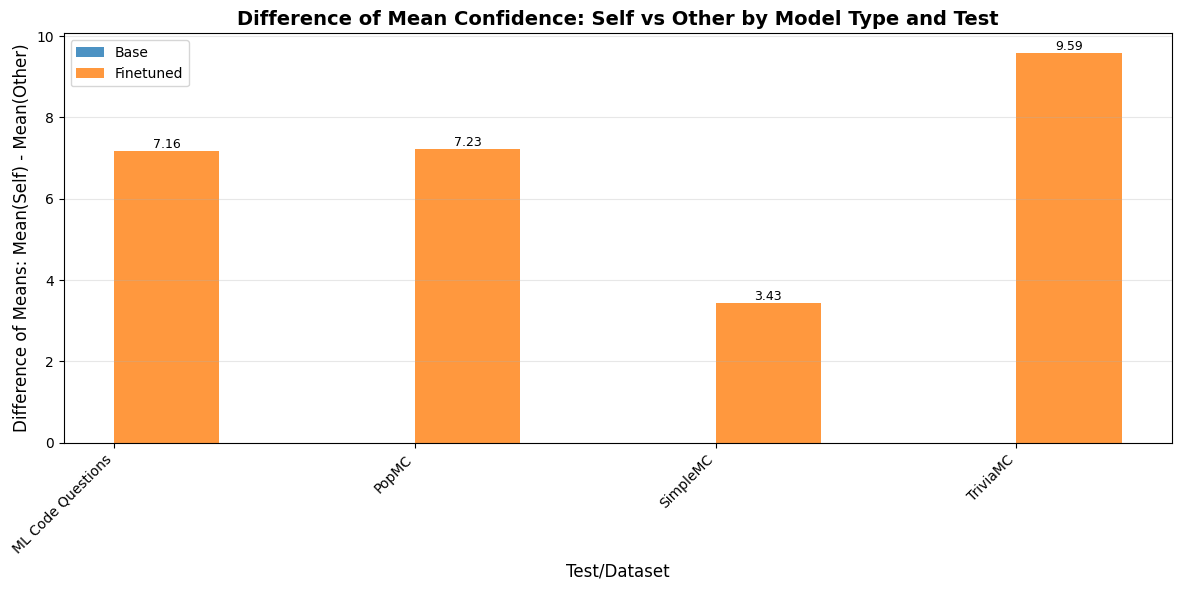


MEAN CONFIDENCE VALUES AND DIFFERENCE BY MODEL TYPE AND TEST
Difference = Mean(Self Confidence) - Mean(Other Confidence)
--------------------------------------------------------------------------------
model_type         test_name  mean_self  mean_other  mean_diff  n_files
 finetuned ML Code Questions  71.661404   64.496773   7.164632        1
 finetuned             PopMC  52.465835   45.234708   7.231126        1
 finetuned          SimpleMC  47.992724   44.564863   3.427860        1
 finetuned          TriviaMC  69.770169   60.180880   9.589290        1


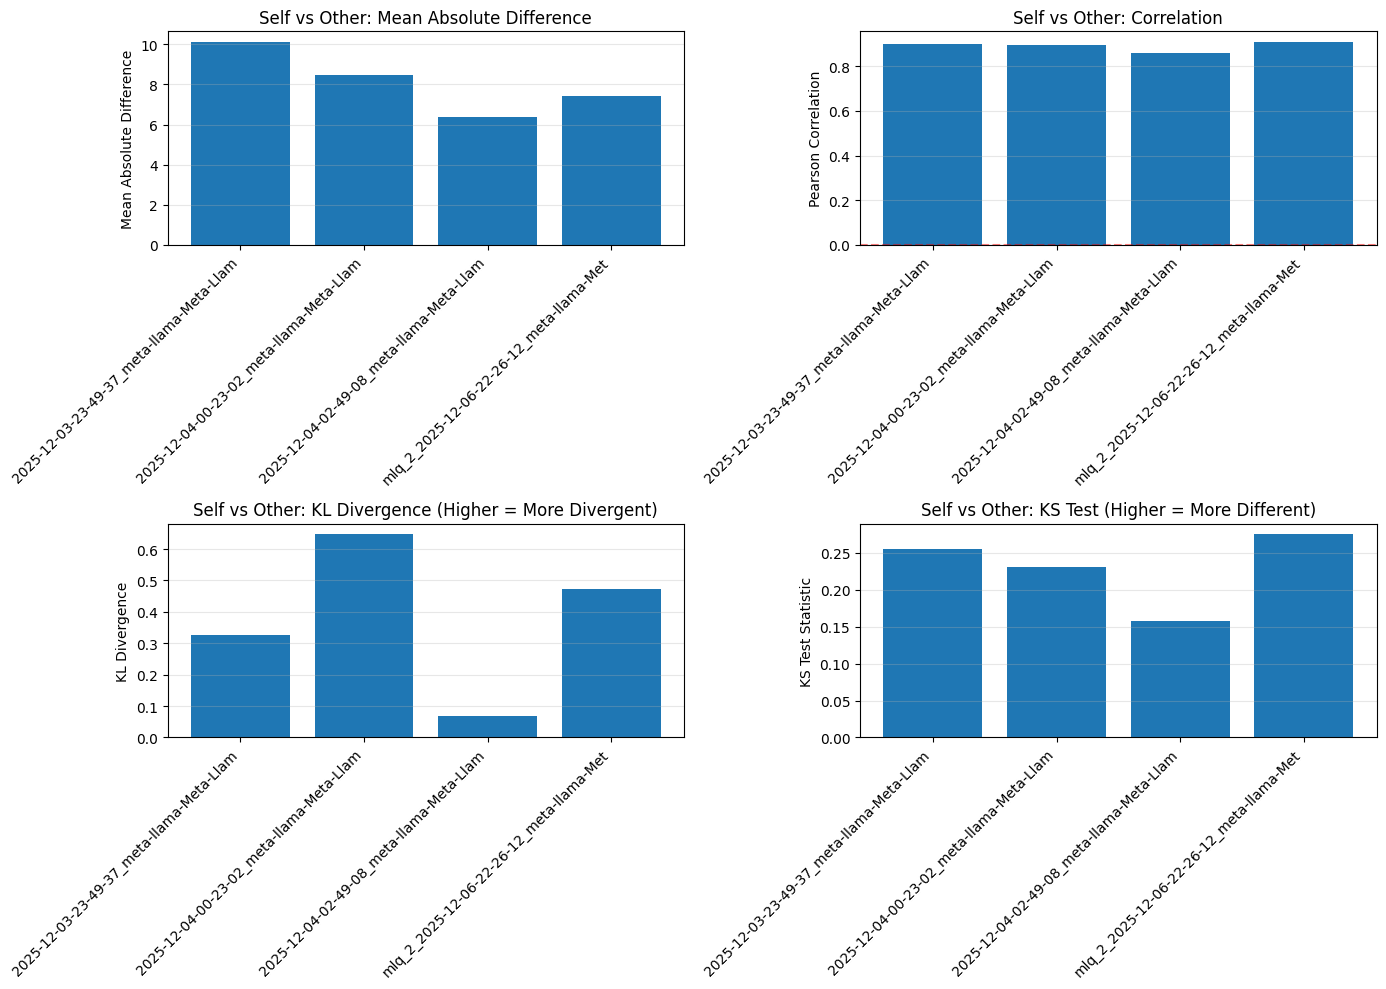

In [7]:
# Chart: Difference of means (Mean(Self) - Mean(Other)) for each model type and test
if all_results:
    df = pd.DataFrame(all_results)
    
    # Print filename with extracted model type and test name for verification
    print("\n" + "="*80)
    print("FILENAME EXTRACTION VERIFICATION")
    print("="*80)
    for _, row in df.iterrows():
        print(f"Filename: {row['filename']}")
        print(f"  -> Model Type: {row['model_type']}, Test Name: {row['test_name']}")
    print("="*80 + "\n")
    
    # Group by model_type and test_name, compute mean difference
    # This computes: Mean(Self Confidence) - Mean(Other Confidence) for each group
    comparison_data = []
    for (model_type, test_name), group in df.groupby(['model_type', 'test_name']):
        # Get mean self and mean other for this group
        mean_self = group['self_conf_mean'].mean()
        mean_other = group['other_conf_mean'].mean()
        mean_diff = mean_self - mean_other
        
        comparison_data.append({
            'model_type': model_type,
            'test_name': test_name,
            'mean_self': mean_self,
            'mean_other': mean_other,
            'mean_diff': mean_diff,  # Mean(Self) - Mean(Other)
            'n_files': len(group)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    if len(comparison_df) > 0:
        # Get unique test names and model types
        test_names = sorted(comparison_df['test_name'].unique())
        available_model_types = sorted(comparison_df['model_type'].unique())
        
        # Check which model types we have
        has_base = 'base' in available_model_types
        has_finetuned = 'finetuned' in available_model_types
        
        print(f"\nAvailable model types: {available_model_types}")
        print(f"Has base: {has_base}, Has finetuned: {has_finetuned}")
        
        # Always use grouped layout (both model types) for consistency
        # This way both bars will show when both model types are present
        width = 0.35
        offset_base = -width/2
        offset_finetuned = width/2
        
        # Create grouped bar chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(test_names))
        
        base_values = []
        finetuned_values = []
        
        for test_name in test_names:
            base_val = comparison_df[(comparison_df['test_name'] == test_name) & 
                                    (comparison_df['model_type'] == 'base')]['mean_diff'].values
            finetuned_val = comparison_df[(comparison_df['test_name'] == test_name) & 
                                          (comparison_df['model_type'] == 'finetuned')]['mean_diff'].values
            
            # Use NaN instead of None for matplotlib compatibility
            base_values.append(base_val[0] if len(base_val) > 0 else np.nan)
            finetuned_values.append(finetuned_val[0] if len(finetuned_val) > 0 else np.nan)
        
        # Always plot both bars (even if one has all NaN values)
        # This ensures both model types appear in the chart structure
        bars1 = ax.bar(x + offset_base, base_values, width, label='Base', alpha=0.8, color='#1f77b4')
        bars2 = ax.bar(x + offset_finetuned, finetuned_values, width, label='Finetuned', alpha=0.8, color='#ff7f0e')
        
        # Debug: print values being plotted
        print(f"\nBase values: {base_values}")
        print(f"Finetuned values: {finetuned_values}")
        print(f"Number of base bars: {len(bars1) if bars1 is not None else 0}")
        print(f"Number of finetuned bars: {len(bars2) if bars2 is not None else 0}")
        
        ax.set_xlabel('Test/Dataset', fontsize=12)
        ax.set_ylabel('Difference of Means: Mean(Self) - Mean(Other)', fontsize=12)
        ax.set_title('Difference of Mean Confidence: Self vs Other by Model Type and Test', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(test_names, rotation=45, ha='right')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if not np.isnan(height) and abs(height) > 0.1:  # Only label if significant
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}',
                           ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed summary table with means
        print("\n" + "="*80)
        print("MEAN CONFIDENCE VALUES AND DIFFERENCE BY MODEL TYPE AND TEST")
        print("="*80)
        print("Difference = Mean(Self Confidence) - Mean(Other Confidence)")
        print("-" * 80)
        display_cols = ['model_type', 'test_name', 'mean_self', 'mean_other', 'mean_diff', 'n_files']
        print(comparison_df[display_cols].to_string(index=False))
    else:
        print("No comparison data available")

# Original comparison charts (all files together)
if all_results:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    filenames = [r['filename'] for r in all_results]
    
    # 1. Mean Absolute Difference
    axes[0, 0].bar(range(len(all_results)), 
                   [r['mean_absolute_difference'] for r in all_results])
    axes[0, 0].set_xticks(range(len(all_results)))
    axes[0, 0].set_xticklabels([f.replace('_comparison.jsonl', '')[:40] for f in filenames], 
                                rotation=45, ha='right')
    axes[0, 0].set_ylabel('Mean Absolute Difference')
    axes[0, 0].set_title('Self vs Other: Mean Absolute Difference')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Correlation
    axes[0, 1].bar(range(len(all_results)), 
                   [r['correlation'] for r in all_results])
    axes[0, 1].set_xticks(range(len(all_results)))
    axes[0, 1].set_xticklabels([f.replace('_comparison.jsonl', '')[:40] for f in filenames], 
                                rotation=45, ha='right')
    axes[0, 1].set_ylabel('Pearson Correlation')
    axes[0, 1].set_title('Self vs Other: Correlation')
    axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. KL Divergence
    axes[1, 0].bar(range(len(all_results)), 
                   [r['kl_divergence'] for r in all_results])
    axes[1, 0].set_xticks(range(len(all_results)))
    axes[1, 0].set_xticklabels([f.replace('_comparison.jsonl', '')[:40] for f in filenames], 
                                rotation=45, ha='right')
    axes[1, 0].set_ylabel('KL Divergence')
    axes[1, 0].set_title('Self vs Other: KL Divergence (Higher = More Divergent)')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. KS Test Statistic
    axes[1, 1].bar(range(len(all_results)), 
                   [r['ks_statistic'] for r in all_results])
    axes[1, 1].set_xticks(range(len(all_results)))
    axes[1, 1].set_xticklabels([f.replace('_comparison.jsonl', '')[:40] for f in filenames], 
                                rotation=45, ha='right')
    axes[1, 1].set_ylabel('KS Test Statistic')
    axes[1, 1].set_title('Self vs Other: KS Test (Higher = More Different)')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


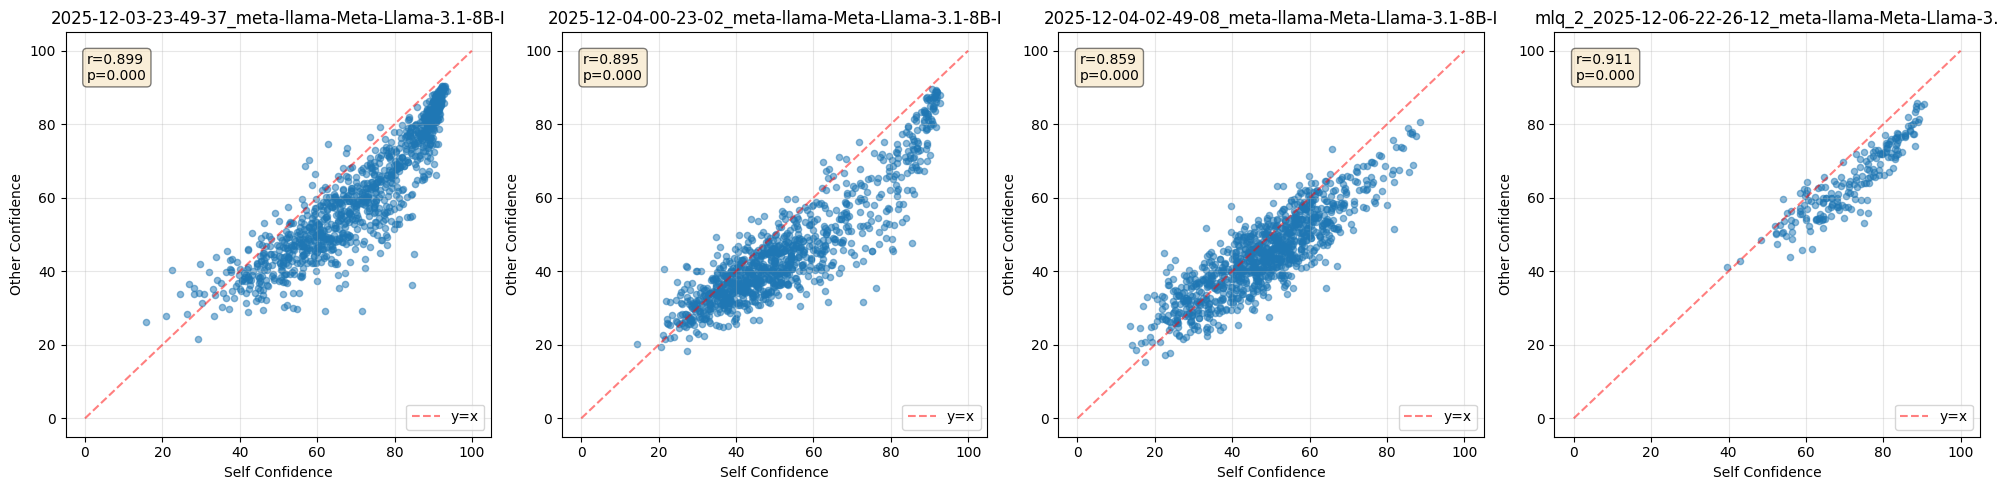

In [8]:
# Detailed scatter plots for each file
if all_results:
    n_files = len(all_results)
    fig, axes = plt.subplots(1, n_files, figsize=(5*n_files, 5))
    if n_files == 1:
        axes = [axes]
    
    for idx, result in enumerate(all_results):
        filepath = result['filepath']
        data = load_comparison_data(filepath)
        conf_data = extract_confidence_values(data)
        
        self_conf = conf_data['self_conf']
        other_conf = conf_data['other_conf']
        
        axes[idx].scatter(self_conf, other_conf, alpha=0.5, s=20)
        axes[idx].plot([0, 100], [0, 100], 'r--', alpha=0.5, label='y=x')
        axes[idx].set_xlabel('Self Confidence')
        axes[idx].set_ylabel('Other Confidence')
        axes[idx].set_title(result['filename'][:50])
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)
        
        # Add correlation text
        if result['correlation'] is not None:
            axes[idx].text(0.05, 0.95, f"r={result['correlation']:.3f}\np={result['correlation_p_value']:.3f}", 
                          transform=axes[idx].transAxes, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()


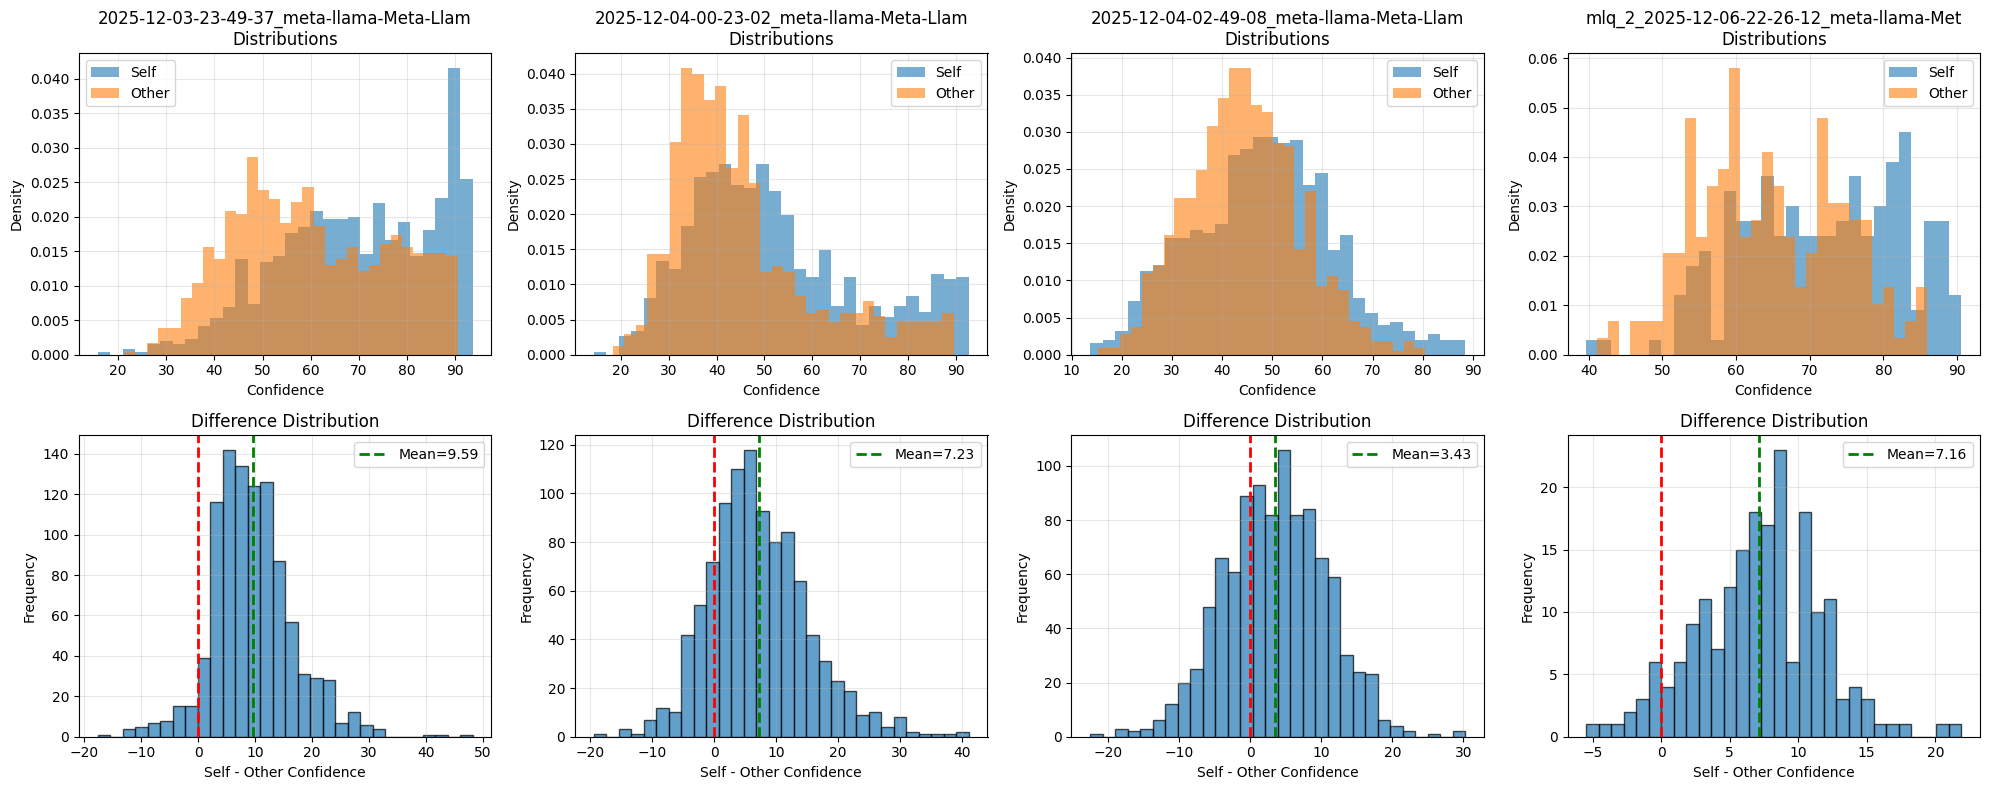

In [9]:
# Distribution comparison plots
if all_results:
    n_files = len(all_results)
    fig, axes = plt.subplots(2, n_files, figsize=(5*n_files, 8))
    if n_files == 1:
        axes = axes.reshape(2, 1)
    
    for idx, result in enumerate(all_results):
        filepath = result['filepath']
        data = load_comparison_data(filepath)
        conf_data = extract_confidence_values(data)
        
        self_conf = conf_data['self_conf']
        other_conf = conf_data['other_conf']
        
        # Histogram comparison
        axes[0, idx].hist(self_conf, bins=30, alpha=0.6, label='Self', density=True)
        axes[0, idx].hist(other_conf, bins=30, alpha=0.6, label='Other', density=True)
        axes[0, idx].set_xlabel('Confidence')
        axes[0, idx].set_ylabel('Density')
        axes[0, idx].set_title(f'{result["filename"][:40]}\nDistributions')
        axes[0, idx].legend()
        axes[0, idx].grid(alpha=0.3)
        
        # Difference distribution
        diff = self_conf - other_conf
        axes[1, idx].hist(diff, bins=30, alpha=0.7, edgecolor='black')
        axes[1, idx].axvline(x=0, color='r', linestyle='--', linewidth=2)
        axes[1, idx].axvline(x=np.mean(diff), color='g', linestyle='--', linewidth=2, label=f'Mean={np.mean(diff):.2f}')
        axes[1, idx].set_xlabel('Self - Other Confidence')
        axes[1, idx].set_ylabel('Frequency')
        axes[1, idx].set_title('Difference Distribution')
        axes[1, idx].legend()
        axes[1, idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [10]:
# Print detailed statistics for each file
if all_results:
    print("\n" + "="*80)
    print("DETAILED STATISTICS")
    print("="*80)
    
    for result in all_results:
        print(f"\n{result['filename']}")
        print("-" * 80)
        print(f"  Samples: {result['n_samples']}")
        print(f"  Self Confidence:  mean={result['self_conf_mean']:.2f}, std={result['self_conf_std']:.2f}")
        print(f"  Other Confidence: mean={result['other_conf_mean']:.2f}, std={result['other_conf_std']:.2f}")
        print(f"  Mean Absolute Difference: {result['mean_absolute_difference']:.3f}")
        print(f"  Correlation: {result['correlation']:.3f} (p={result['correlation_p_value']:.4f})")
        print(f"  KL Divergence: {result['kl_divergence']:.4f}")
        print(f"  KS Test: statistic={result['ks_statistic']:.4f}, p={result['ks_p_value']:.4f}")
        
        if 'bin_mean_absolute_difference' in result:
            print(f"  Bin-wise Mean Absolute Difference: {result['bin_mean_absolute_difference']:.4f}")
            print("  Bin-wise Differences:")
            for bin_letter in 'ABCDEFGH':
                if bin_letter in result.get('bin_differences', {}):
                    print(f"    {bin_letter}: {result['bin_differences'][bin_letter]:.4f}")



DETAILED STATISTICS

2025-12-03-23-49-37_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_TriviaMC_n500_comparison.jsonl
--------------------------------------------------------------------------------
  Samples: 1002
  Self Confidence:  mean=69.77, std=16.26
  Other Confidence: mean=60.18, std=16.03
  Mean Absolute Difference: 10.136
  Correlation: 0.899 (p=0.0000)
  KL Divergence: 0.3270
  KS Test: statistic=0.2550, p=0.0000

2025-12-04-00-23-02_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_PopMC_0_difficulty_filtered_test_n500_comparison.jsonl
--------------------------------------------------------------------------------
  Samples: 1002
  Self Confidence:  mean=52.47, std=17.90
  Other Confidence: mean=45.23, std=14.90
  Mean Absolute Difference: 8.450
  Correlation: 0.895 (p=0.0000)
  KL Divergence: 0.6478
  KS Test: statistic=0.2310, p=0.0000

2025-12-04-02-49-08_meta-llama-Meta-Llama-3.1-8B-